# CS 541 Final Project

## 1. Loading Dataset

In [ ]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#dataset source - https://www.kaggle.com/datasets/dansbecker/nba-shot-logs
df = pd.read_csv("shot_logs.csv")

In [ ]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


## 2. Data Cleaning

#### Fixing and dropping features


##### Matchup gives an idea about the date and teams. These are not relevant for a player, so dropping this.

In [ ]:
df.MATCHUP

0         MAR 04, 2015 - CHA @ BKN
1         MAR 04, 2015 - CHA @ BKN
2         MAR 04, 2015 - CHA @ BKN
3         MAR 04, 2015 - CHA @ BKN
4         MAR 04, 2015 - CHA @ BKN
                    ...           
128064    OCT 29, 2014 - BKN @ BOS
128065    OCT 29, 2014 - BKN @ BOS
128066    OCT 29, 2014 - BKN @ BOS
128067    OCT 29, 2014 - BKN @ BOS
128068    OCT 29, 2014 - BKN @ BOS
Name: MATCHUP, Length: 128069, dtype: object

In [ ]:
df = df.drop(['MATCHUP'], axis = 1)

##### Location, whether the team is home team or an away team, irrelevant so dropping this.

In [ ]:
df.LOCATION

0         A
1         A
2         A
3         A
4         A
         ..
128064    A
128065    A
128066    A
128067    A
128068    A
Name: LOCATION, Length: 128069, dtype: object

In [ ]:
df = df.drop(['LOCATION'], axis = 1)

##### Gives the same information as the FGM, drop this feature

In [ ]:
df = df.drop(['W'], axis = 1)

In [ ]:
df = df.drop(['SHOT_NUMBER'], axis = 1)

###### Formatting of time is inappropriate for using, convert this to amount of seconds left in a period

In [ ]:
df.GAME_CLOCK

0          1:09
1          0:14
2          0:00
3         11:47
4         10:34
          ...  
128064     1:52
128065    11:28
128066    11:10
128067     2:37
128068     0:12
Name: GAME_CLOCK, Length: 128069, dtype: object

In [ ]:
df['SECONDS_LEFT_IN_PERIOD'] = df['GAME_CLOCK'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['LAST_SHOT'] = 0
df.loc[df['SECONDS_LEFT_IN_PERIOD'] <= 1, 'LAST_SHOT'] = 1

In [ ]:
df = df.drop(['GAME_CLOCK'], axis = 1)

##### Fix negative touch time

In [ ]:
df = df[df['TOUCH_TIME'] >= 0]

##### Shot result gives same information as the FGM, so drop this feature

In [ ]:
df = df.drop(['SHOT_RESULT'], axis = 1)

##### Dropping type of points


In [ ]:
df = df.drop(['PTS'], axis = 1)

Dropping null values

In [ ]:
df.isna().any()

GAME_ID                       False
FINAL_MARGIN                  False
PERIOD                        False
SHOT_CLOCK                     True
DRIBBLES                      False
TOUCH_TIME                    False
SHOT_DIST                     False
PTS_TYPE                      False
CLOSEST_DEFENDER              False
CLOSEST_DEFENDER_PLAYER_ID    False
CLOSE_DEF_DIST                False
FGM                           False
player_name                   False
player_id                     False
SECONDS_LEFT_IN_PERIOD        False
LAST_SHOT                     False
dtype: bool

In [ ]:
df["SHOT_CLOCK"].fillna(df["SHOT_CLOCK"].mean(), inplace=True)

#####Creating shot marker 

In [ ]:
df['SHOT_MARKER'] = df['FGM'].replace(['0', '1'], ['0', '^'], inplace=False)

##### Get absolute value of margin

In [ ]:
df['ABS_FINAL_MARGIN'] = abs(df['FINAL_MARGIN'])

### Exploring data for extracting more relevant information

Just knowing the closest defender is not a useful feature, so improving on available features. Finding the blocking efficiency of the defender. Also, using the information of efficiency with count of blocked shots, and attempted shots, a ranking for the defenders is obtained. 

In [ ]:
defenders = df[['CLOSEST_DEFENDER_PLAYER_ID', 'CLOSEST_DEFENDER']]

In [ ]:
df['CLOSEST_DEFENDER_EFFICIENCY'] = [0.0] * len(df)

for defender_id in df['CLOSEST_DEFENDER_PLAYER_ID']:
    temp_df = df[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id]
    temp_eff = (temp_df['FGM'] == 0).sum() / temp_df['FGM'].count()
    df.loc[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id, 'CLOSEST_DEFENDER_EFFICIENCY'] = temp_eff
    
    blockedShots = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id) & (df['FGM'] == 0)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    allShots = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKED_SHOTS'] = blockedShots
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = allShots
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKING_EFFICIENCY'] = blockedShots/allShots


<ipython-input-21-b9da4a6c6868>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKED_SHOTS'] = blockedShots
<ipython-input-21-b9da4a6c6868>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = allShots
<ipython-input-21-b9da4a6c6868>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [ ]:
defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','BLOCKED_SHOTS', 'BLOCKING_EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

<ipython-input-22-d03921630f36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','BLOCKED_SHOTS', 'BLOCKING_EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)


In [ ]:
defenders

,CLOSEST_DEFENDER_PLAYER_ID,CLOSEST_DEFENDER,BLOCKED_SHOTS,ALL_SHOTS,BLOCKING_EFFICIENCY,CLOSEST_DEFENDER_RANK
0,101187,"Anderson, Alan",209.0,382.0,0.547120,135
1,202711,"Bogdanovic, Bojan",189.0,319.0,0.592476,173
2,202711,"Bogdanovic, Bojan",189.0,319.0,0.592476,173
3,203900,"Brown, Markel",27.0,50.0,0.540000,388
4,201152,"Young, Thaddeus",275.0,531.0,0.517891,56
...,...,...,...,...,...,...
128064,203935,"Smart, Marcus",163.0,294.0,0.554422,203
128065,202323,"Turner, Evan",292.0,497.0,0.587525,77
128066,201977,"Thornton, Marcus",71.0,127.0,0.559055,327
128067,202340,"Bradley, Avery",247.0,448.0,0.551339,105


In [ ]:
df.describe()

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,player_id,SECONDS_LEFT_IN_PERIOD,LAST_SHOT,SHOT_MARKER,ABS_FINAL_MARGIN,CLOSEST_DEFENDER_EFFICIENCY
count,1.277570e+05,127757.000000,127757.000000,127757.000000,127757.00000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000,127757.00000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000
mean,2.140045e+07,0.209789,2.469595,12.450301,2.02828,2.778727,13.576808,2.264964,159043.963399,4.124012,0.452468,157229.09032,351.409011,0.010473,0.452468,10.720477,0.547532
std,2.578955e+02,13.235094,1.139929,5.629991,3.48057,2.987196,8.887801,0.441316,78788.073182,2.756188,0.497738,79369.28322,207.602250,0.101801,0.497738,7.764161,0.038680
min,2.140000e+07,-53.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.000000,708.000000,0.000000,0.000000,708.00000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.140023e+07,-8.000000,1.000000,8.400000,0.00000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,101162.00000,172.000000,0.000000,0.000000,5.000000,0.524064
50%,2.140045e+07,1.000000,2.000000,12.450301,1.00000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,201939.00000,352.000000,0.000000,0.000000,9.000000,0.547059
75%,2.140067e+07,9.000000,3.000000,16.400000,2.00000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,202704.00000,531.000000,0.000000,1.000000,15.000000,0.569472
max,2.140091e+07,53.000000,7.000000,24.000000,32.00000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,204060.00000,720.000000,1.000000,1.000000,53.000000,1.000000


#### Aggregating features for each player

##### Get mean of the features for each player

In [ ]:
aggFn = {'player_name': 'first', 'player_id' : 'first','PERIOD': 'mean', 'SHOT_CLOCK': 'mean', 'DRIBBLES': 'mean','TOUCH_TIME': 'mean', 'SHOT_DIST': 'mean', 'CLOSE_DEF_DIST': 'mean','CLOSEST_DEFENDER_EFFICIENCY': 'mean', 'LAST_SHOT': 'mean'}
players = df.groupby(df['player_name'], as_index=False).aggregate(aggFn)


##### Get count of shots attempted by a player, count of successful shots, and using these get an approximate shooting efficiency

In [ ]:
for player_id in players['player_id']:
    df_temp = df[df['player_id'] == player_id]
    players.loc[(players['player_id'] == player_id), 'ATTEMPTED_SHOTS'] = df_temp['FGM'].count()
    players.loc[(players['player_id'] == player_id), 'BASKETS'] = (df_temp['FGM'] == 1).sum()
    players.loc[(players['player_id'] == player_id), 'SHOOTING_EFFICIENCY'] = ((df_temp['FGM'] == 1).sum())/df_temp['FGM'].count()
    
    df.loc[(df['player_id'] == player_id), 'ATTEMPTED_SHOTS'] = df_temp['FGM'].count()
    df.loc[(df['player_id'] == player_id), 'BASKETS'] = (df_temp['FGM'] == 1).sum()
    df.loc[(df['player_id'] == player_id), 'SHOOTING_EFFICIENCY'] = ((df_temp['FGM'] == 1).sum())/df_temp['FGM'].count()

#### Plot the features to understand how they affect the result of a shot

<Axes: xlabel='PERIOD', ylabel='Count'>

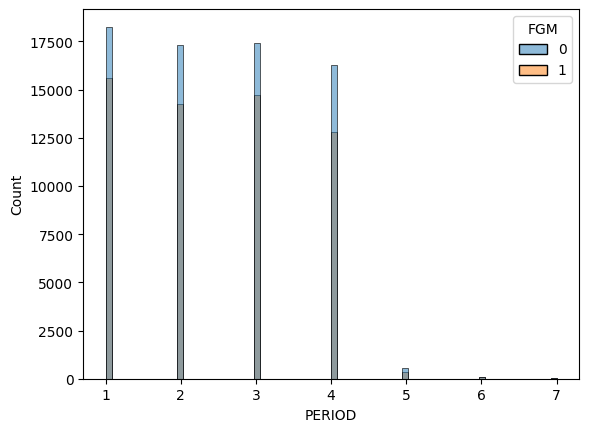

In [ ]:
sns.histplot(df, x="PERIOD", hue="FGM", element="bars")

<Axes: xlabel='SHOT_CLOCK', ylabel='Count'>

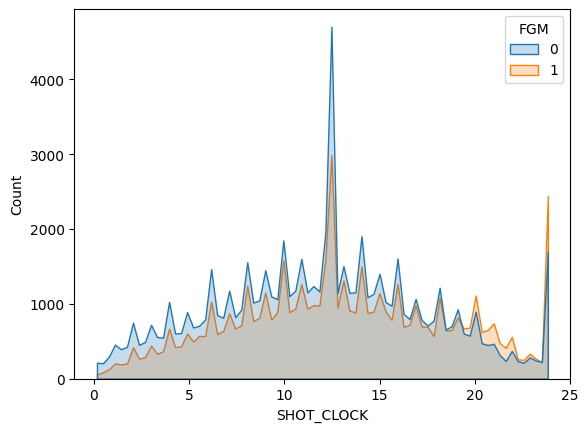

In [ ]:
sns.histplot(df, x="SHOT_CLOCK", hue="FGM", element="poly")

<Axes: xlabel='DRIBBLES', ylabel='count'>

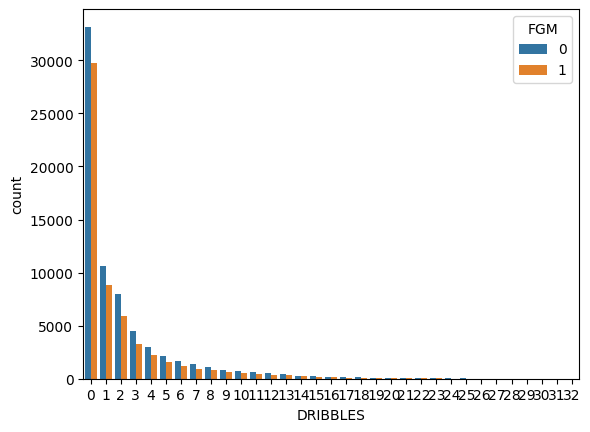

In [ ]:
sns.countplot(data=df, x='DRIBBLES', hue='FGM')

<Axes: xlabel='TOUCH_TIME', ylabel='Count'>

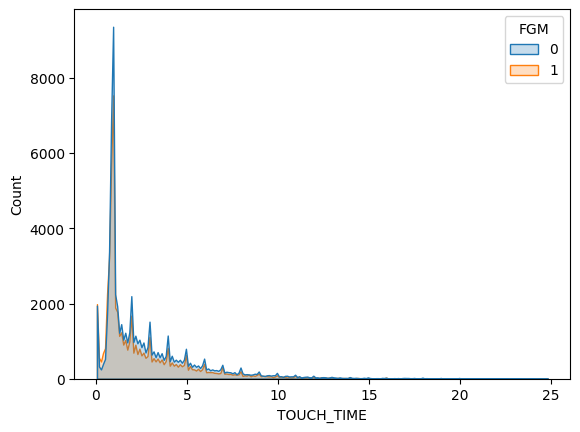

In [ ]:
sns.histplot(df, x="TOUCH_TIME", hue="FGM", element="poly")

<Axes: xlabel='SHOT_DIST', ylabel='Count'>

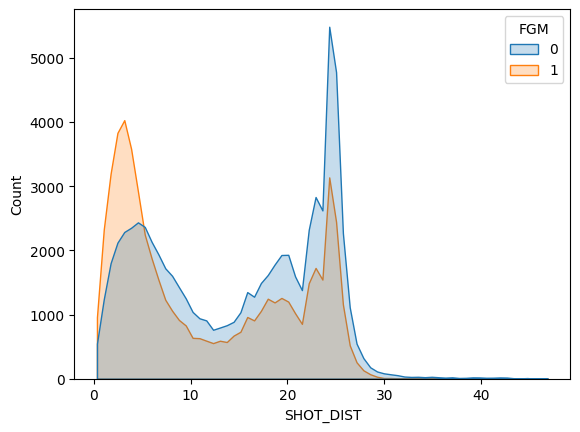

In [ ]:
sns.histplot(df, x="SHOT_DIST", hue="FGM", element="poly")

<Axes: xlabel='CLOSE_DEF_DIST', ylabel='Count'>

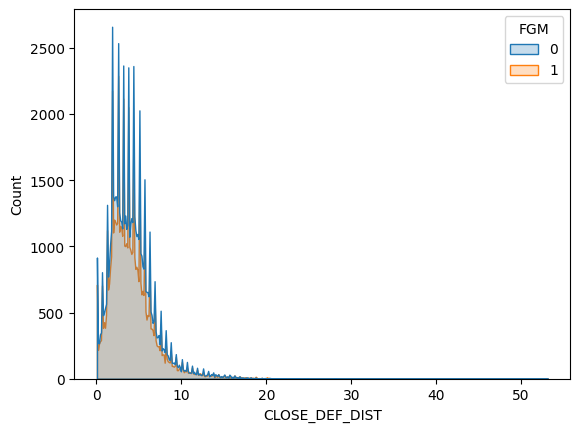

In [ ]:
sns.histplot(df, x="CLOSE_DEF_DIST", hue="FGM", element="poly")

<Axes: xlabel='CLOSEST_DEFENDER_EFFICIENCY', ylabel='Count'>

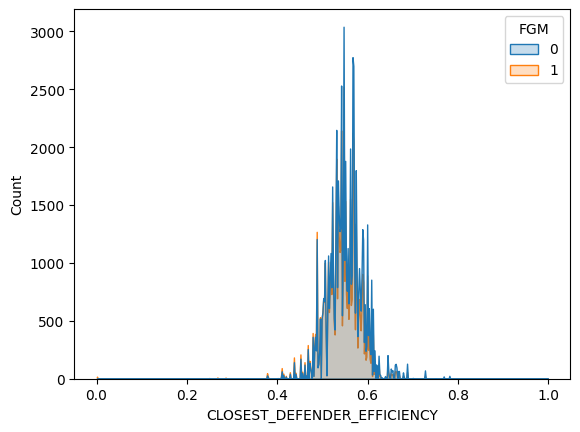

In [ ]:
sns.histplot(df, x="CLOSEST_DEFENDER_EFFICIENCY", hue="FGM", element="poly")

<Axes: xlabel='SECONDS_LEFT_IN_PERIOD', ylabel='Count'>

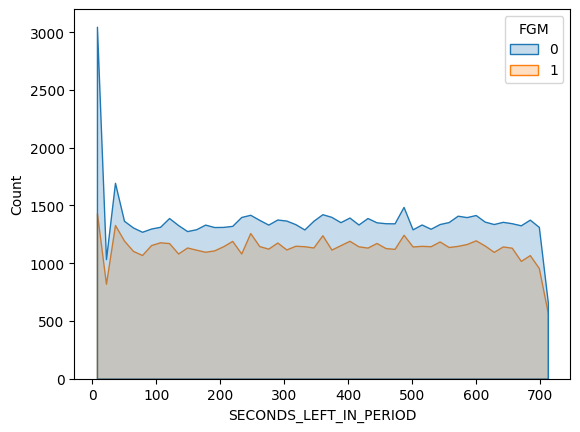

In [ ]:
sns.histplot(df, x="SECONDS_LEFT_IN_PERIOD", hue="FGM", element="poly")

#### Find correlation between features

In [ ]:
selected_features = df[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY','SECONDS_LEFT_IN_PERIOD','FGM']].copy()

<Axes: >

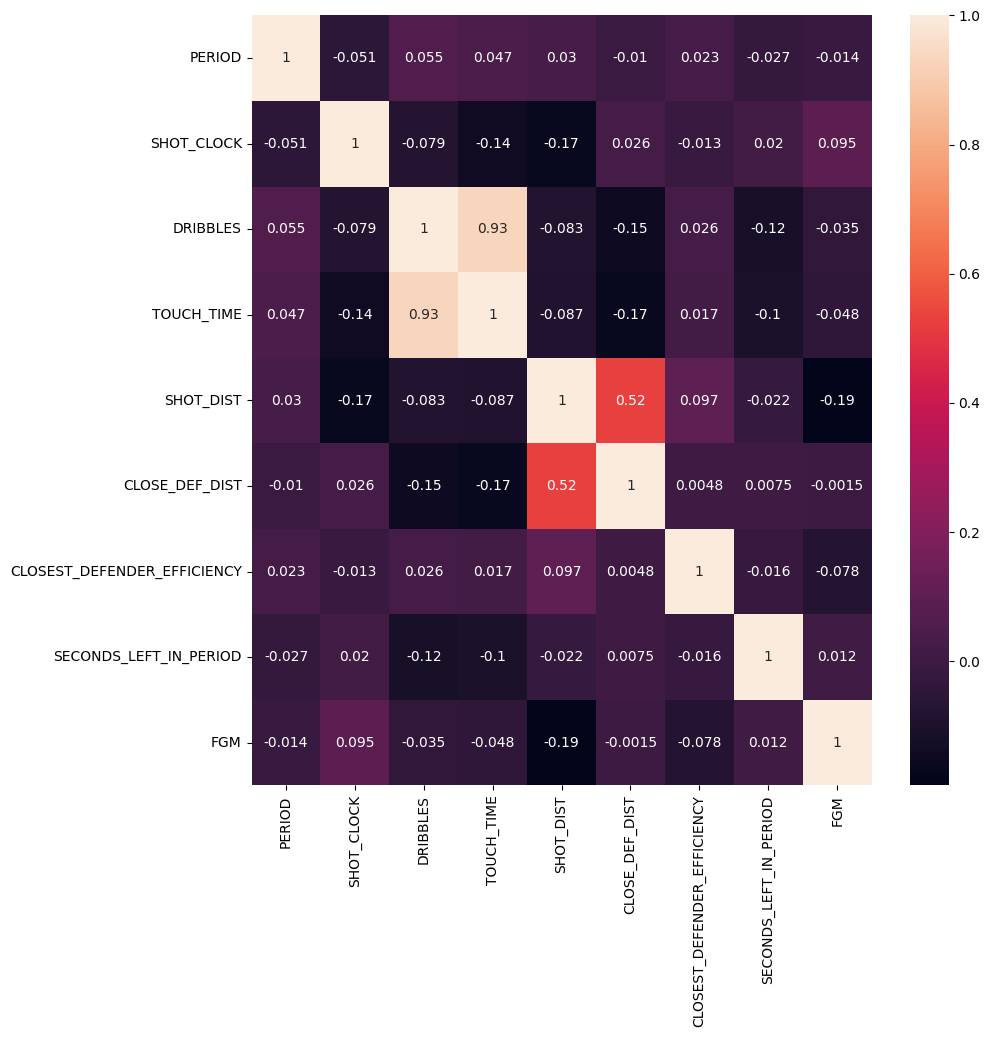

In [ ]:
corr = selected_features.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True)

### Clustering Shots by Context

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


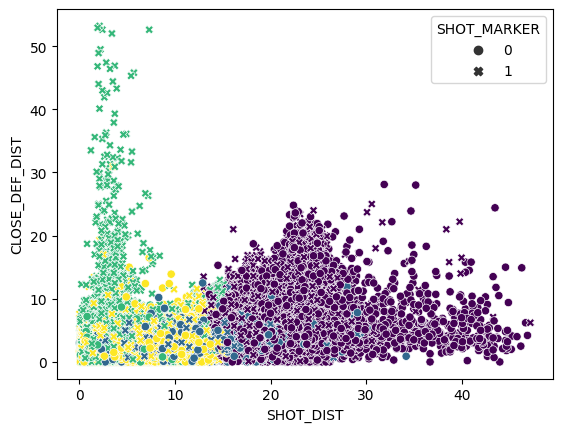

In [ ]:
# Clustering

kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']])
# not using SECONDS_LEFT_IN_PERIOD, using LAST_SHOT instead

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['CLUSTER'] = kmeans.labels_
for label in range(0, 4):
    print(label, float(sum(df[df['CLUSTER'] == label]['FGM'])) / float(len(df[df['CLUSTER'] == label]['FGM'])))

0 0.3738060631229236
1 0.41198291366906475
2 0.6007950251889169
3 0.4843666750792182


In [ ]:
# Create Cluster average columns

for col in ['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']:
  df['CLUSTER_'+col+'_AVG'] = [0.0] * len(df)
df['CLUSTER_SHOOTING_EFFICIENCY'] = [0.0] * len(df)

for cluster_id in list(df['CLUSTER'].unique()):
  df.loc[df['CLUSTER'] == cluster_id, 'CLUSTER_SHOOTING_EFFICIENCY']  = float(sum(df[df['CLUSTER'] == cluster_id]['FGM'])) / float(len(df[df['CLUSTER'] == cluster_id]['FGM']))
  for col in ['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']:
    temp_avg = df[df['CLUSTER'] == cluster_id][col].mean()
    df.loc[df['CLUSTER'] == cluster_id, 'CLUSTER_'+col+'_AVG'] = temp_avg


In [ ]:
df.head()

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,...,CLUSTER,CLUSTER_PERIOD_AVG,CLUSTER_SHOT_CLOCK_AVG,CLUSTER_DRIBBLES_AVG,CLUSTER_TOUCH_TIME_AVG,CLUSTER_SHOT_DIST_AVG,CLUSTER_CLOSE_DEF_DIST_AVG,CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG,CLUSTER_LAST_SHOT_AVG,CLUSTER_SHOOTING_EFFICIENCY
0,21400899,24,1,10.800000,2,1.9,7.7,2,"Anderson, Alan",101187,...,3,2.465831,8.850141,1.685118,2.786621,6.480048,2.604588,0.544521,0.009170,0.484367
1,21400899,24,1,3.400000,0,0.8,28.2,3,"Bogdanovic, Bojan",202711,...,0,2.478440,11.793875,0.931219,1.836432,22.124856,5.681565,0.550443,0.015383,0.373806
2,21400899,24,1,12.450301,3,2.7,10.1,2,"Bogdanovic, Bojan",202711,...,3,2.465831,8.850141,1.685118,2.786621,6.480048,2.604588,0.544521,0.009170,0.484367
3,21400899,24,2,10.300000,2,1.9,17.2,2,"Brown, Markel",203900,...,0,2.478440,11.793875,0.931219,1.836432,22.124856,5.681565,0.550443,0.015383,0.373806
4,21400899,24,2,10.900000,2,2.7,3.7,2,"Young, Thaddeus",201152,...,3,2.465831,8.850141,1.685118,2.786621,6.480048,2.604588,0.544521,0.009170,0.484367


In [ ]:
# compare cluster average efficiency to the total average efficiency and reward/penalize for makes/misses

avg_efficiency = sum(df['FGM']) / len(df)

players['Adjusted_Efficiency'] = [0.0] * len(players)
for pid in players['player_id']:
  temp_df = df[df['player_id'] == pid]
  adj_attempts = 0
  adj_makes = 0
  for shot in temp_df.iterrows():
    adj_attempts += 1
    if shot[1]['FGM'] == 0:
      if shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] >= avg_efficiency:
        adj_attempts += 2 * (shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] - avg_efficiency)
      else:
        adj_attempts -= 2 * (avg_efficiency - shot[1]['CLUSTER_SHOOTING_EFFICIENCY'])
    else:
      adj_makes += 1
      if shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] >= avg_efficiency:
        adj_makes -= 2 * (shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] - avg_efficiency)
      else:
        adj_makes += 2 * (avg_efficiency - shot[1]['CLUSTER_SHOOTING_EFFICIENCY'])
  players.loc[players['player_id'] == pid, 'Adjusted_Efficiency'] = adj_makes/adj_attempts


In [ ]:
# get adjustment percentage

players['Adjustment'] = players['Adjusted_Efficiency'] - players['SHOOTING_EFFICIENCY']

In [ ]:
#players[['player_id','BASKETS', 'Adjusted_Efficiency']].sort_values(by=['BASKETS','Adjusted_Efficiency'], ascending = False)
#players[['player_id', 'player_name', 'Adjusted_Efficiency', 'Adjustment']].sort_values(by=['Adjusted_Efficiency', 'Adjustment'], ascending = False).head()
test = players[players['ATTEMPTED_SHOTS'] > players['ATTEMPTED_SHOTS'].mean()].sort_values(by=['Adjusted_Efficiency', 'Adjustment'], ascending = False)

In [ ]:
#test_df = players[['player_id']]
#test_df["Player_Rank"] = players[['BASKETS', 'Adjusted_Efficiency']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

test_df = test[['player_id']]
test_df["Player_Rank"] = test[['Adjusted_Efficiency']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

<ipython-input-44-c09cfefe6a36>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Player_Rank"] = test[['Adjusted_Efficiency']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)


In [ ]:
test_df.sort_values(by = 'Player_Rank')

,player_id,Player_Rank
162,2594,1
127,200755,2
3,201143,3
49,101108,4
75,1717,5
...,...,...
245,203524,121
12,203083,122
148,202702,123
192,203487,124


### Empirical Evaluation using Rank Based Overlap and Kendall-Tau Approach

About RBO : https://ai.plainenglish.io/comparing-top-k-rankings-statistically-9adfc9cfc98b

RBO and Kendall Tau : https://towardsdatascience.com/rbo-v-s-kendall-tau-to-compare-ranked-lists-of-items-8776c5182899

Dataset from ESPN : https://docs.google.com/spreadsheets/d/1HkOGJh743FG2Y0BRtyaQuUX5vmn2_yKnezbhe8gUz4E/edit?usp=share_link

Source : http://www.espn.com/nba/hollinger/statistics/_/page/1/year/2015

In [ ]:
df2 = pd.read_csv('ESPN_NBA15_Stats - Sheet1.csv')
pn = df2['player_name'].str.split(',', n = 2, expand = True)
df2['player_name'] = pn[0].str.lower()
df2 = df2.iloc[:281]
df2 = df2.sort_values(by = 'player_name')


In [ ]:
df2 = df2.sort_values(by='TS%', ascending=False)
df2 = df2.iloc[:len(test_df)]
df2['new_rank'] = range(1,len(df2)+1)
df2 = df2.sort_values(by = 'player_name')

In [ ]:
S = test_df["Player_Rank"].values.tolist()
#T = df2["Player_Rank"].values.tolist()
T = df2["new_rank"].values.tolist()


In [ ]:
import math
def rbo(list1, list2, p = 0.99):
    def helper(ret, i, d):
        l1 = set(list1[:i]) if i < len(list1) else set(list1)
        l2 = set(list2[:i]) if i < len(list2) else set(list2)
        a_d = len(l1.intersection(l2))/i
        term = math.pow(p, i) * a_d
        if d == i:
            return ret + term
        return helper(ret + term, i + 1, d)
    k = max(len(list1), len(list2))
    x_k = len(set(list1).intersection(set(list2)))
    summation = helper(0, 1, k)
    return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)


In [ ]:
rbo(S, T)*100

58.08479877143403

In [ ]:
import scipy.stats as stats
tau, p_value = stats.kendalltau(S, T)
print('Tau : ', tau, '\nP : ', p_value)
test.to_csv('output.csv')

Tau :  0.01161290322580645 
P :  0.8476931637768975


###***** Everything below TBD

### Predicting shot output


In [ ]:
#@title
X = selected_features.drop('FGM', axis = 1)
y = selected_features['FGM']

In [ ]:
#@title
sns.distplot(y)

#### Decision Tree

In [ ]:
#@title
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#@title
X_DT = selected_features.drop('FGM', axis = 1)
y_DT = selected_features['FGM']
X_DT_train, X_DT_val, y_DT_train, y_DT_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#@title
modelDT = DecisionTreeClassifier(random_state=0)
modelDT.fit(X_DT_train, y_DT_train)

In [ ]:
#@title
y_DT_pred = modelDT.predict(X_DT_val)

In [ ]:
#@title
accuracyDT = accuracy_score(y_DT_val, y_DT_pred)
print("Accuracy: {:.2f}%".format(accuracyDT * 100))

### Logistic Regression

In [ ]:
#@title
from sklearn.linear_model import LogisticRegression

In [ ]:
#@title
X_LR = selected_features.drop('FGM', axis = 1)
y_LR = selected_features['FGM']
X_LR_train, X_LR_val, y_LR_train, y_LR_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#@title
modelLR = LogisticRegression(max_iter=1000)
modelLR.fit(X_LR_train, y_LR_train)

In [ ]:
#@title
y_LR_pred = modelLR.predict(X_LR_val)

In [ ]:
#@title
accuracyLR = accuracy_score(y_LR_val, y_LR_pred)
print("Accuracy: {:.2f}%".format(accuracyLR * 100))

#### K Nearest Neighbors

In [ ]:
#@title
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#@title
X_KNN = selected_features.drop('FGM', axis = 1)
y_KNN = selected_features['FGM']
X_KNN_train, X_KNN_val, y_KNN_train, y_KNN_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#@title
modelKNN = KNeighborsClassifier()
modelKNN.fit(X_KNN_train, y_KNN_train)

In [ ]:
#@title
y_KNN_pred = modelKNN.predict(X_KNN_val)

In [ ]:
#@title
accuracyKNN = accuracy_score(y_KNN_val, y_KNN_pred)
print("Accuracy: {:.2f}%".format(accuracyKNN * 100))

### Naive Bayes

In [ ]:
#@title
from sklearn.naive_bayes import GaussianNB

In [ ]:
#@title
X_NB = selected_features.drop('FGM', axis = 1)
y_NB = selected_features['FGM']
X_NB_train, X_NB_val, y_NB_train, y_NB_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#@title
modelNB = GaussianNB()
modelNB.fit(X_NB_train, y_NB_train)

In [ ]:
#@title
y_NB_pred = modelNB.predict(X_NB_val)

In [ ]:
#@title
accuracyNB = accuracy_score(y_NB_val, y_NB_pred)
print("Accuracy: {:.2f}%".format(accuracyNB * 100))

### SGD

In [ ]:
#@title
from sklearn.linear_model import SGDClassifier

In [ ]:
#@title
X_SGD = selected_features.drop('FGM', axis = 1)
y_SGD = selected_features['FGM']
X_SGD_train, X_SGD_val, y_SGD_train, y_SGD_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#@title
modelSGD = SGDClassifier()
modelSGD.fit(X_SGD_train, y_SGD_train)

In [ ]:
#@title
y_SGD_pred = modelSGD.predict(X_SGD_val)

In [ ]:
#@title
accuracySGD = accuracy_score(y_SGD_val, y_SGD_pred)
print("Accuracy: {:.2f}%".format(accuracySGD * 100))

### Finding feature importance with best classifier

In [ ]:
#@title
accuracies = pd.DataFrame({'Approach': ['Decision Tree', 'Logistic Regression', 'K Nearest Neighbors', 'Naive Bayes' ,'SGD'], 'Accuracy': [accuracyDT*100, accuracyLR*100, accuracyKNN*100, accuracyNB*100, accuracySGD*100]})

In [ ]:
#@title
accuracies.sort_values(by = 'Accuracy', ascending = False)

In [ ]:
#@title
importance = modelLR.coef_[0]

In [ ]:
#@title
impt = pd.DataFrame({"Features": X.columns, "Feature_Importance": importance})
impt = impt.sort_values(by = 'Feature_Importance', ascending = False)
print(impt)

In [ ]:
#@title
periodImpt = impt[impt.Features == 'PERIOD'].Feature_Importance
shotClkImpt = impt[impt.Features == 'SHOT_CLOCK'].Feature_Importance
dribblesImpt = impt[impt.Features == 'DRIBBLES'].Feature_Importance
ttImpt = impt[impt.Features == 'TOUCH_TIME'].Feature_Importance
shotDistImpt = impt[impt.Features == 'SHOT_DIST'].Feature_Importance
closeDefDistImpt = impt[impt.Features == 'CLOSE_DEF_DIST'].Feature_Importance
closeDefEffImpt = impt[impt.Features == 'CLOSEST_DEFENDER_EFFICIENCY'].Feature_Importance
secLeftImpt = impt[impt.Features == 'SECONDS_LEFT_IN_PERIOD'].Feature_Importance


In [ ]:
#@title
df.describe()

In [ ]:
#@title
players_data

In [ ]:
#@title
for i in players_data['player_id']:
    temp = players_data[players_data['player_id'] == i]
    #Period
    if temp['PERIOD'].iloc[0] > df['PERIOD'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = 0
    else:
      reward = abs((df['PERIOD'].mean()-temp['PERIOD'])/(df['PERIOD'].max() - df['PERIOD'].mean()))*periodImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = reward
    
    #Shot Clock    
    if temp['SHOT_CLOCK'].iloc[0] > df['SHOT_CLOCK'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['SHOT_CLOCK']-df['SHOT_CLOCK'].mean())/(df['SHOT_CLOCK'].max() - df['SHOT_CLOCK'].mean()))*shotClkImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    
    #Dribbles    
    if temp['DRIBBLES'].iloc[0] > df['DRIBBLES'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['DRIBBLES']-df['DRIBBLES'].mean())/(df['DRIBBLES'].max() - df['DRIBBLES'].mean()))*dribblesImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    
    #Touch time    
    if temp['TOUCH_TIME'].iloc[0] > df['TOUCH_TIME'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['TOUCH_TIME']-df['TOUCH_TIME'].mean())/(df['TOUCH_TIME'].max() - df['TOUCH_TIME'].mean()))*ttImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Shot Distance
    if temp['shot_distance'].iloc[0] > df['SHOT_DIST'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['shot_distance']-df['SHOT_DIST'].mean())/(df['SHOT_DIST'].max() - df['SHOT_DIST'].mean()))*shotDistImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Closest Defender Distance
    if temp['CLOSE_DEF_DIST'].iloc[0] > df['CLOSE_DEF_DIST'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['CLOSE_DEF_DIST']-df['CLOSE_DEF_DIST'].mean())/(df['CLOSE_DEF_DIST'].max() - df['CLOSE_DEF_DIST'].mean()))*closeDefDistImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Closest Defender Efficiency
    if temp['CLOSEST_DEFENDER_EFFICIENCY'].iloc[0] > df['CLOSEST_DEFENDER_EFFICIENCY'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['CLOSEST_DEFENDER_EFFICIENCY']-df['CLOSEST_DEFENDER_EFFICIENCY'].mean())/(df['CLOSEST_DEFENDER_EFFICIENCY'].max() - df['CLOSEST_DEFENDER_EFFICIENCY'].mean()))*closeDefEffImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Seconds left in period
    if temp['SECONDS_LEFT_IN_PERIOD'].iloc[0] > df['SECONDS_LEFT_IN_PERIOD'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['SECONDS_LEFT_IN_PERIOD']-df['SECONDS_LEFT_IN_PERIOD'].mean())/(df['SECONDS_LEFT_IN_PERIOD'].max() - df['SECONDS_LEFT_IN_PERIOD'].mean()))*secLeftImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    

In [ ]:
#@title
players_data

In [ ]:
#@title
players_data['SHOOTER_RANK'] = players_data[['ATTEMPTED_SHOTS', 'SUCCESSFUL_SHOTS', 'SHOOTING_ACCURACY', 'Weighted_Sum']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

In [ ]:
#@title
players_data.sort_values(by = 'SHOOTER_RANK', ascending = False)

https://www.basketball-reference.com/leagues/NBA_2015_shooting.html

## Clustering (OLD)

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['SHOT_DIST', 'CLOSE_DEF_DIST']])

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['SD_CDD_LABELS'] = kmeans.labels_
for label in range(0, 4):
  print(label, float(sum(df[df['SD_CDD_LABELS'] == label]['FGM'])) / float(len(df[df['SD_CDD_LABELS'] == label]['FGM'])))

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['DRIBBLES', 'TOUCH_TIME']])

sns.scatterplot(x=df['DRIBBLES'], y=df['TOUCH_TIME'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['D_TT_LABELS'] = kmeans.labels_
for label in range(0, 4):
  print(label, float(sum(df[df['D_TT_LABELS'] == label]['FGM'])) / float(len(df[df['D_TT_LABELS'] == label]['FGM'])))

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['SHOT_DIST', 'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'PTS_TYPE', 'CLOSEST_DEFENDER_EFFICIENCY']])

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['FULL_CONDITIONS_LABELS'] = kmeans.labels_
for label in range(0, 4):
  print(label, float(sum(df[df['FULL_CONDITIONS_LABELS'] == label]['FGM'])) / float(len(df[df['FULL_CONDITIONS_LABELS'] == label]['FGM'])))

In [ ]:
df[['SHOT_DIST', 'FULL_CONDITIONS_LABELS']].sort_values('SHOT_DIST', ascending=False).head()

In [ ]:
df[['CLOSE_DEF_DIST', 'FULL_CONDITIONS_LABELS']].sort_values('CLOSE_DEF_DIST', ascending=False).head()